link: https://pytorch.org/text/_modules/torchtext/datasets/text_classification.html

In [1]:
#원본코드인데.. 이미 가공된 데이터셋을 ngrams 처리해서 불러오기 때문에 입력데이터를 dataset에 맞게 수정해야 한다.

import torch
import torchtext
from torchtext.datasets import text_classification

### DATASET (ag news Data 가져고 와서 실행하기)

>  .data/train.csv <br/>
>  .data/test.csv  <br/>

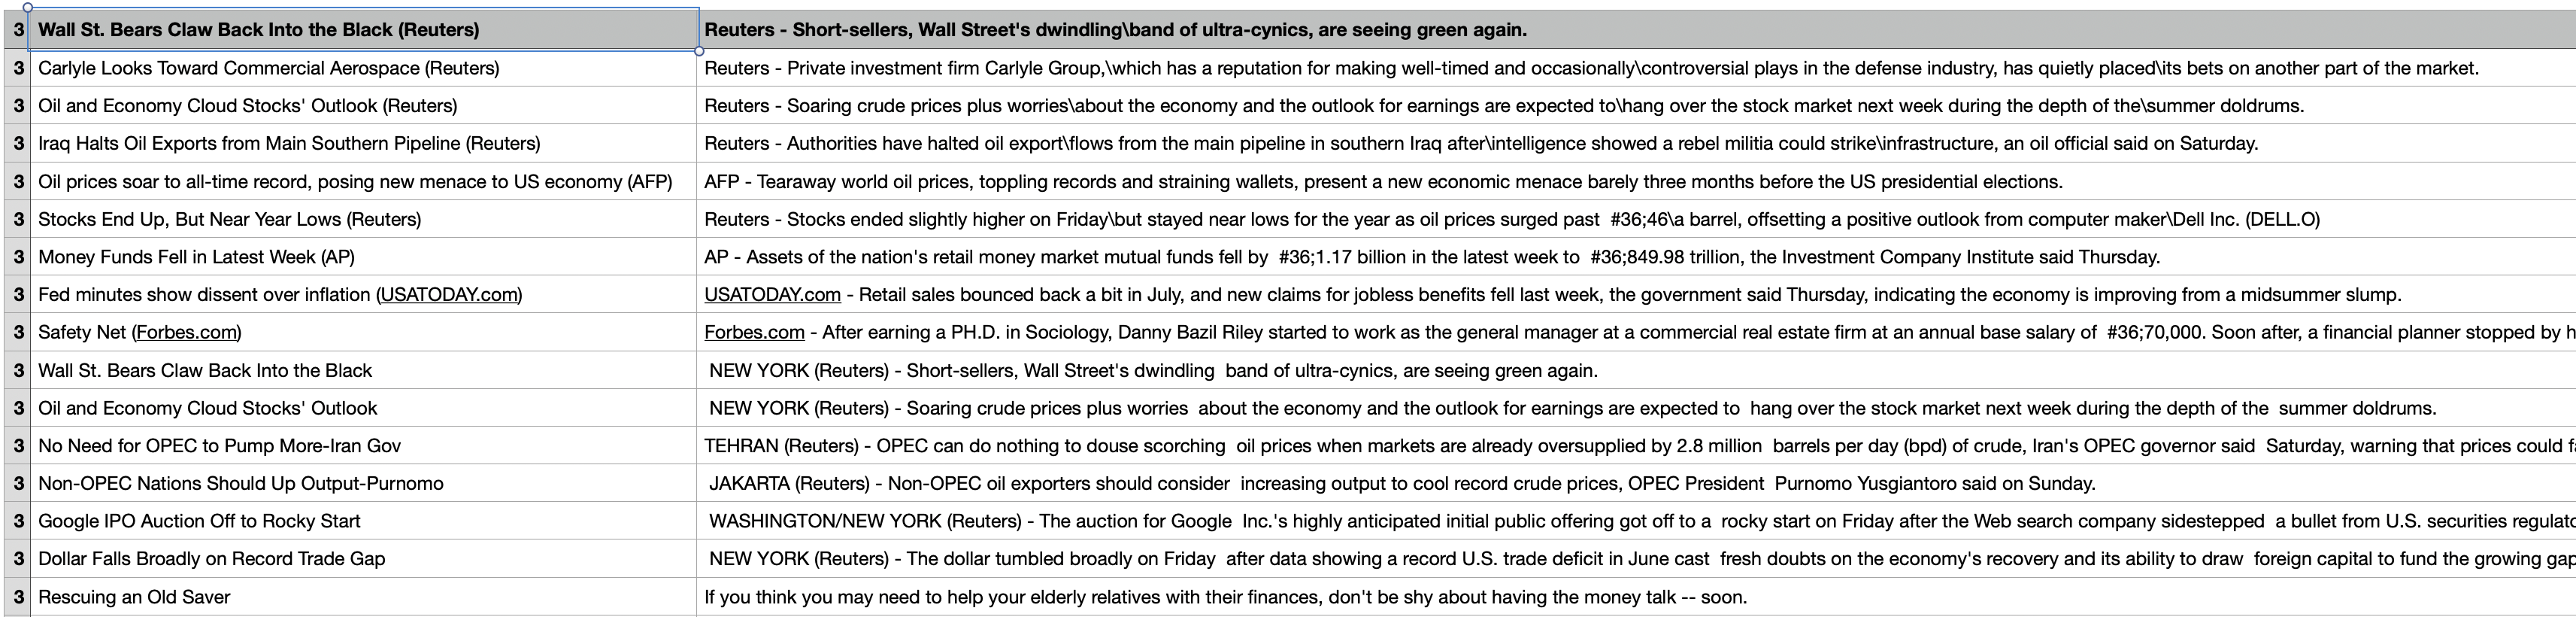


### Label 

> -World       0  <br/>
> -Sports      1  <br/>
> -Business    2  <br/>
> -Sci/Tech    3  


In [22]:
NGRAMS = 2

import os

if not os.path.isdir('ag_news_Data'):
    os.mkdir('ag_news_Data')
    
    
#text_classification.DATASETS의 구조를 보고 결과데이터를 어떻게 생성하는지 분석하거나 이하 학습코드를 분석    
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='ag_news_Data', ngrams=NGRAMS, vocab=None) 
# ref : https://pytorch.org/text/datasets.html#ag-news
# https://pytorch.org/text/_modules/torchtext/datasets/text_classification.html


BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

120000lines [00:07, 17017.63lines/s]
120000lines [00:12, 9876.53lines/s] 
7600lines [00:00, 9841.84lines/s]


### DATASET (csv 파일을 통해서 가지고 오기)

> data/test.csv  <br>
> data/train.csv

In [2]:
import torch
import io
import os

from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive, unicode_csv_reader
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

from tqdm import tqdm

In [ ]:
def _csv_iterator(data_path, ngrams, yield_cls=False):
    tokenizer = get_tokenizer("basic_english")
    with io.open(data_path, encoding="utf8") as f:
        reader = unicode_csv_reader(f)
        for row in reader:
            tokens = ' '.join(row[1:])
            tokens = tokenizer(tokens)
            if yield_cls:
                yield int(row[0]) - 1, ngrams_iterator(tokens, ngrams)
            else:
                yield ngrams_iterator(tokens, ngrams)
                
def _create_data_from_iterator(vocab, iterator, include_unk):
    data = []
    labels = []
    with tqdm(unit_scale=0, unit='lines') as t:
        for cls, tokens in iterator:
            if include_unk:
                tokens = torch.tensor([vocab[token] for token in tokens])
            else:
                token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token]
                                        for token in tokens]))
                tokens = torch.tensor(token_ids)
            if len(tokens) == 0:
                logging.info('Row contains no tokens.')
            data.append((cls, tokens))
            labels.append(cls)
            t.update(1)
    return data, set(labels)

In [12]:
class TextClassificationDataset(torch.utils.data.Dataset):

    def __init__(self, vocab, data, labels):
      
        super(TextClassificationDataset, self).__init__()
        self._data = data
        self._labels = labels
        self._vocab = vocab
        
    def __getitem__(self, i):
        return self._data[i]

    def __len__(self):
        return len(self._data)

    def __iter__(self):
        for x in self._data:
            yield x

    def get_labels(self):
        return self._labels

    def get_vocab(self):
        return self._vocab

In [13]:
NGRAMS = 2
ngrams=1 
include_unk = False

train_csv_path='data/train.csv'    
test_csv_path='data/test.csv'    
    

vocab = build_vocab_from_iterator(_csv_iterator(train_csv_path, ngrams))
        
    
train_data, train_labels = _create_data_from_iterator(
    vocab, _csv_iterator(train_csv_path, ngrams, yield_cls=True), include_unk)

test_data, test_labels = _create_data_from_iterator(
    vocab, _csv_iterator(test_csv_path, ngrams, yield_cls=True), include_unk)

train_dataset, test_dataset = (TextClassificationDataset(vocab, train_data, train_labels),
            TextClassificationDataset(vocab, test_data, test_labels))

BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

120000lines [00:04, 29881.08lines/s]
120000lines [00:06, 17829.20lines/s]
7600lines [00:00, 18261.24lines/s]


In [76]:
print(train_data[0:2])
print()
print(type(train_labels))

[(2, tensor([  432,   426,     2,  1606, 14839,   114,    67,     3,   849,    14,
           28,    15,    28,    16, 50726,     4,   432,   375,    17,    10,
        67508,     7, 52259,     4,    43,  4010,   784,   326,     2])), (2, tensor([15875,  1073,   855,  1311,  4251,    14,    28,    15,    28,    16,
          930,   798,   321, 15875,    99,     4, 27658,    29,     6,  4460,
           12,   565, 52791,     9, 80618,  2126,     8,     3,   526,   242,
            4,    29,  3891, 82815,  6575,    11,   207,   360,     7,     3,
          127,     2]))]

<class 'set'>


In [14]:
train_dataset[0:2]

[(2,
  tensor([  432,   426,     2,  1606, 14839,   114,    67,     3,   849,    14,
             28,    15,    28,    16, 50726,     4,   432,   375,    17,    10,
          67508,     7, 52259,     4,    43,  4010,   784,   326,     2])),
 (2,
  tensor([15875,  1073,   855,  1311,  4251,    14,    28,    15,    28,    16,
            930,   798,   321, 15875,    99,     4, 27658,    29,     6,  4460,
             12,   565, 52791,     9, 80618,  2126,     8,     3,   526,   242,
              4,    29,  3891, 82815,  6575,    11,   207,   360,     7,     3,
            127,     2]))]

In [15]:
test_dataset[1:3]

[(3,
  tensor([    3,   494,    22,    11,   128,   930,   112,  1099,   422,  1839,
             12,   762, 10410,    14,   181,     2,   173,    15,   181,     2,
            173,    16,   738,     4,   567,    54,     6,     0,     7, 29617,
           3955,    12,     3,   469,   205,    83,  6156,  2003,  1140,     4,
              6,  3584,     0,  8082, 14648,   181,   838,     4,    29,  2447,
            135,     3,     0,  1839,    12,    23,  4398,  1201,     2])),
 (3,
  tensor([10971,     2,    55,   403,  4342,     5,   524, 33249,    14,    32,
             15,    32,    16,     6,    55,  7371,    25,     6, 10102,  5111,
             21,     3,   597,     7,  4174,   193,     6,  4342,     5,  1405,
              6,  7215,     7,  4401,   638, 33249,     4,   104,    43,   950,
           7022,     7, 42476, 23433,     4,     3,  1104,  4336,     7, 12636,
              2]))]

In [23]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [24]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [25]:
VOCAB_SIZE,EMBED_DIM,NUN_CLASS

(95812, 32, 4)

In [29]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [36]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    
    for i, (text, offsets, cls) in tqdm(enumerate(data)):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

In [37]:
def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [38]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

7125it [00:09, 726.71it/s]
70it [00:00, 698.99it/s]

Epoch: 1  | time in 0 minutes, 9 seconds
	Loss: 0.0085(train)	|	Acc: 95.2%(train)
	Loss: 0.0000(valid)	|	Acc: 94.0%(valid)


7125it [00:09, 727.34it/s]
71it [00:00, 702.73it/s]

Epoch: 2  | time in 0 minutes, 9 seconds
	Loss: 0.0074(train)	|	Acc: 95.8%(train)
	Loss: 0.0001(valid)	|	Acc: 94.9%(valid)


7125it [00:09, 726.69it/s]
142it [00:00, 703.97it/s]

Epoch: 3  | time in 0 minutes, 9 seconds
	Loss: 0.0066(train)	|	Acc: 96.3%(train)
	Loss: 0.0001(valid)	|	Acc: 95.2%(valid)


7125it [00:09, 729.14it/s]
69it [00:00, 683.53it/s]

Epoch: 4  | time in 0 minutes, 9 seconds
	Loss: 0.0059(train)	|	Acc: 96.7%(train)
	Loss: 0.0001(valid)	|	Acc: 94.7%(valid)


7125it [00:09, 728.92it/s]


Epoch: 5  | time in 0 minutes, 9 seconds
	Loss: 0.0054(train)	|	Acc: 96.9%(train)
	Loss: 0.0002(valid)	|	Acc: 94.8%(valid)


In [39]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0002(test)	|	Acc: 90.2%(test)


In [60]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        
        print("output:",output)
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

vocab = train_dataset.get_vocab()
model = model.to("cpu")

In [63]:
class_type = ag_news_label[predict(ex_text_str, model, vocab, 1)]
print("This is a  news of {}.%".format(class_type))

output: tensor([[-1.1396, 10.3498, -5.6390, -3.7604]])
This is a  news of Sports.%



>  ag_news_label = { <br/>
>                  1 : "World",  <br/>
>                 2 : "Sports",   <br/>
>                 3 : "Business", <br/>
>                 4 : "Sci/Tec"}  <br/>